# ICORES 2020

In [1]:
import csv
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

from lime.lime_text import LimeTextExplainer

from ortools.graph import pywrapgraph

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import math

from sklearn.metrics import precision_recall_fscore_support

from sklearn.externals import joblib

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/nkanak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nkanak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Data has been retrieved from the publicly accessible Jira instance of the open source projects of Apache Foundation.
# Check this URL: https://issues.apache.org/jira .
with open('all_issues_minified.json') as f:
    issues = json.load(f)
issues = issues['issues']

In [3]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [4]:
# Keep only the issues with assignee (HADOOP project).
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [5]:
len(issues)

228969

In [6]:
# TODO: Modify me!
NUMBER_OF_DEVELOPERS_INCLUDED = 21
most_common = Counter([issue['fields']['assignee']['key'] for issue in issues]).most_common(NUMBER_OF_DEVELOPERS_INCLUDED)
most_common

[('adobejira', 29458),
 ('davsclaus', 6180),
 ('njiang', 2057),
 ('aonishuk', 1564),
 ('tabish121', 1506),
 ('shazron', 1473),
 ('aantonenko', 1229),
 ('andrus', 1216),
 ('atkach', 1145),
 ('wesmckinn', 1141),
 ('julianhyde', 1111),
 ('andy.seaborne', 1101),
 ('purplecabbage', 1086),
 ('ababiichuk', 1028),
 ('batik-dev@xmlgraphics.apache.org', 1027),
 ('djohnson', 979),
 ('jbellis', 967),
 ('ancosen', 914),
 ('elserj', 881),
 ('bowserj', 869),
 ('onechiporenko', 866)]

In [7]:
included_developers = [developer_name for developer_name, _ in most_common]

In [8]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in included_developers]

In [9]:
included_developers

['adobejira',
 'davsclaus',
 'njiang',
 'aonishuk',
 'tabish121',
 'shazron',
 'aantonenko',
 'andrus',
 'atkach',
 'wesmckinn',
 'julianhyde',
 'andy.seaborne',
 'purplecabbage',
 'ababiichuk',
 'batik-dev@xmlgraphics.apache.org',
 'djohnson',
 'jbellis',
 'ancosen',
 'elserj',
 'bowserj',
 'onechiporenko']

In [10]:
len(included_developers)

21

In [11]:
len(issues)

57798

In [12]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'njiang': 0, 'ancosen': 1, 'atkach': 2, 'shazron': 3, 'djohnson': 4, 'jbellis': 5, 'wesmckinn': 6, 'aonishuk': 7, 'onechiporenko': 8, 'ababiichuk': 9, 'davsclaus': 10, 'andrus': 11, 'bowserj': 12, 'julianhyde': 13, 'purplecabbage': 14, 'aantonenko': 15, 'elserj': 16, 'adobejira': 17, 'tabish121': 18, 'andy.seaborne': 19, 'batik-dev@xmlgraphics.apache.org': 20}


In [13]:
columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [14]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

In [15]:
issues_df = pd.DataFrame.from_dict(columns)

In [16]:
issues_df['class'].value_counts()

adobejira                           29458
davsclaus                            6180
njiang                               2057
aonishuk                             1564
tabish121                            1506
shazron                              1473
aantonenko                           1229
andrus                               1216
atkach                               1145
wesmckinn                            1141
julianhyde                           1111
andy.seaborne                        1101
purplecabbage                        1086
ababiichuk                           1028
batik-dev@xmlgraphics.apache.org     1027
djohnson                              979
jbellis                               967
ancosen                               914
elserj                                881
bowserj                               869
onechiporenko                         866
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

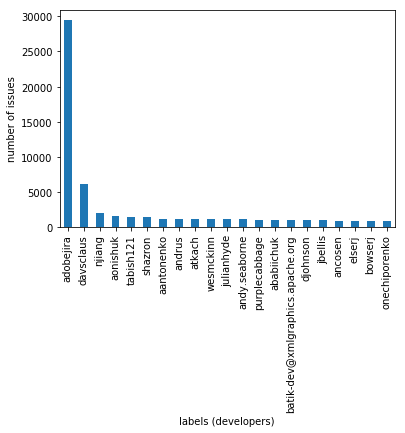

In [17]:
ax = issues_df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

In [18]:
issues_df['class'].value_counts(normalize=True)

adobejira                           0.509672
davsclaus                           0.106924
njiang                              0.035589
aonishuk                            0.027060
tabish121                           0.026056
shazron                             0.025485
aantonenko                          0.021264
andrus                              0.021039
atkach                              0.019810
wesmckinn                           0.019741
julianhyde                          0.019222
andy.seaborne                       0.019049
purplecabbage                       0.018790
ababiichuk                          0.017786
batik-dev@xmlgraphics.apache.org    0.017769
djohnson                            0.016938
jbellis                             0.016731
ancosen                             0.015814
elserj                              0.015243
bowserj                             0.015035
onechiporenko                       0.014983
Name: class, dtype: float64

## Example

In [19]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)

In [20]:
X = issues_df['text']
y = issues_df['label']

# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.33, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])
print('Number of features %s' % X_test.shape[1])

Train size 38724
Test size 19074
Number of features 144944


In [ ]:
def pickle_model(filename, model):
    joblib.dump(model, filename)

# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
print('Naive bayes #####')
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
print(naive_clf.score(X_test,y_test))
y_predicted = naive_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/naive_clf.gz', naive_clf)

print('Logistic Regression #####')
logistic_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logistic_clf.fit(X_train, y_train)
print(logistic_clf.score(X_test, y_test))
y_predicted = logistic_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/logistic_clf.gz', logistic_clf)

print('SVM ######')
svm_clf = SVC(gamma='auto') 
svm_clf.fit(X_train, y_train)
print(svm_clf.score(X_test, y_test))
y_predicted = svm_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/svm_clf.gz', svm_clf)

print('k-NN #####')
number_of_neighbors = math.ceil(math.log2(len(issues_df)))
print('number of neighbors: %s' % (number_of_neighbors))
knn_clf = KNeighborsClassifier(n_neighbors=number_of_neighbors)
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_test, y_test))
y_predicted = knn_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/knn_clf.gz', knn_clf)

print('k-NN sqrt #####')
number_of_neighbors = math.ceil(math.sqrt(len(issues_df)))
print('number of neighbors: %s' % (number_of_neighbors))
knn_clf = KNeighborsClassifier(n_neighbors=number_of_neighbors)
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_test, y_test))
y_predicted = knn_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/knn_clf_sqrt.gz', knn_clf)

print('Neural Network 1000 500 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(1000, 500), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_1000_500.gz', neural_clf)

print('Neural Network 2000 1000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(2000, 1000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_2000_1000.gz', neural_clf)

print('Neural Network 3000 2000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(3000, 2000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_3000_2000.gz', neural_clf)

print('Neural Network 4000 1000 #####')
neural_clf = MLPClassifier(solver='adam', hidden_layer_sizes=(4000, 1000), random_state=42)
neural_clf.fit(X_train, y_train)
print(neural_clf.score(X_test, y_test))
y_predicted = neural_clf.predict(X_test)
print(precision_recall_fscore_support(y_test, y_predicted, average='micro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='macro'))
print(precision_recall_fscore_support(y_test, y_predicted, average='weighted'))
pickle_model('trained_models/neural_clf_4000_1000.gz', neural_clf)

Naive bayes #####
0.8139351997483485
(0.8139351997483485, 0.8139351997483485, 0.8139351997483485, None)
(0.7814146457862783, 0.574919890303864, 0.6173828865979648, None)
(0.8363068749150397, 0.8139351997483485, 0.7950237649377737, None)
Logistic Regression #####


/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8529411764705882
(0.8529411764705882, 0.8529411764705882, 0.8529411764705882, None)
(0.7317182098285725, 0.7062109569641452, 0.7176962549340358, None)
(0.8494885095389072, 0.8529411764705882, 0.8504944421502303, None)
SVM ######
0.5282583621683967
(0.5282583621683967, 0.5282583621683967, 0.5282583621683967, None)
(0.6386695672089543, 0.0732304201239423, 0.07804597479661265, None)
(0.5833987125120258, 0.5282583621683967, 0.38553962346218273, None)


/home/nkanak/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


k-NN #####
number of neighbors: 16
0.6821851735346545
(0.6821851735346545, 0.6821851735346545, 0.6821851735346545, None)
(0.5089495633064745, 0.37382975510443467, 0.3958786959125006, None)
(0.6795385590586908, 0.6821851735346545, 0.6592431710240743, None)
k-NN sqrt #####
number of neighbors: 241
0.5967809583726539
(0.5967809583726539, 0.5967809583726539, 0.5967809583726539, None)
(0.6277154435286779, 0.18472529338194216, 0.2135013781793965, None)
(0.6280486440146706, 0.5967809583726539, 0.5104307012443379, None)
Neural Network 1000 500 #####
0.853413022963196
(0.853413022963196, 0.853413022963196, 0.853413022963196, None)
(0.7338756236456276, 0.7069228679203037, 0.7178254866490826, None)
(0.8500871343652813, 0.853413022963196, 0.850464870830599, None)
Neural Network 2000 1000 #####
0.8601237286358394
(0.8601237286358394, 0.8601237286358394, 0.8601237286358394, None)
(0.7413154962114045, 0.7181969965428442, 0.7281346867273417, None)
(0.8573429555577936, 0.8601237286358394, 0.85777393317

In [ ]:
len(cv.vocabulary_)

In [ ]:
len(cv.get_feature_names())

In [ ]:
len(cv.stop_words_)

In [ ]:
# arr = X_transformed.toarray()

In [ ]:
"""fieldnames = ['assignee', 'word']
with open('word_frequencies_per_assignee.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    for name in unique_person_names:
        x = issues_df[issues_df['class'] == name].index.values.tolist()
        for i in range(arr.shape[1]):
            if arr[x, i].sum() > 0:
                for idx in range(arr[x, i].sum()):
                    csv_writer.writerow({
                        'assignee': name,
                        'word': cv.get_feature_names()[i],
                        #'frequency': arr[x, i].sum(),
                    })
                #print((name, cv.get_feature_names()[i], arr[x, i].sum()))
"""

In [ ]:
"""fieldnames = ['assignee'] + cv.get_feature_names()
with open('spss_input.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    for i in range(len(issues)):
        d = {}
        d['assignee'] = issues_df['class'][i]
        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):
            d[feature] = value
        csv_writer.writerow(d)
"""

In [ ]:
"""with open('spss_input_grouped_by_developer_name.csv', 'w') as f:
    csv_writer = csv.DictWriter(f, fieldnames=fieldnames)
    csv_writer.writeheader()
    d = {}
    for developer in included_developers:
        d[developer] = {
            'assignee': developer
        }
        for feature in cv.get_feature_names():
            d[developer][feature] = 0
            
    for i in range(len(issues)):
        for (feature, value) in zip(cv.get_feature_names(),X_transformed[i].toarray()[0]):
            d[issues_df['class'][i]][feature] += value
    for developer in included_developers:
        csv_writer.writerow(d[developer])
"""

In [ ]:
# load the model from disk
#loaded_model = joblib.load('trained_models/naive_clf.gz')
#result = loaded_model.score(X_test, y_test)
#print(result)